# DenseNet201 Model

### Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet201

###Define constants

In [2]:
TRAIN_PATH = "/content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/Training"
TEST_PATH = "/content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/Testing"
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32
NUM_EPOCHS = 50

### Create data generators for training and validation with advanced data augmentation

In [3]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4405 images belonging to 4 classes.
Found 1100 images belonging to 4 classes.
Found 1281 images belonging to 4 classes.


### Load the pre-trained DenseNet201 model without top layers

In [4]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

74836368/74836368 [==============================] - 4s 0us/step


### Add new fully connected layers on top of the base model

In [5]:
x = Flatten()(base_model.output)
prediction = Dense(train_generator.num_classes, activation='softmax')(x)

### Create the model

In [6]:
model = Model(inputs=base_model.input, outputs=prediction)

### Freeze the pre-trained layers in the base model and train only the new layers

In [7]:
for layer in base_model.layers:
    layer.trainable = False

### Model Summary

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

### Visualize the model architecture

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.417813 to fit



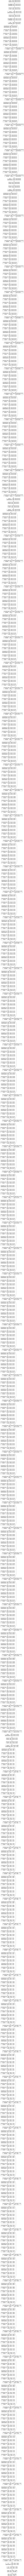

In [9]:
plot_model(model=model, show_shapes=True)

### Compile the model with categorical cross-entropy loss and a lower learning rate

In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy'])

### Save the Model

In [11]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/DenseNet201_Final.h5', 
                              monitor='val_accuracy', 
                              save_best_only=True, 
                              mode='max', 
                              verbose=1)

### Train the model on training data and evaluate on validation data

In [12]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[checkpoint])

Epoch 1/50
138/138 [==============================] - ETA: 0s - loss: 0.6030 - accuracy: 0.7635 
Epoch 1: val_accuracy improved from -inf to 0.74364, saving model to /content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/DenseNet201_Final.h5
138/138 [==============================] - 2508s 18s/step - loss: 0.6030 - accuracy: 0.7635 - val_loss: 0.7463 - val_accuracy: 0.7436
Epoch 2/50
138/138 [==============================] - ETA: 0s - loss: 0.3527 - accuracy: 0.8677
Epoch 2: val_accuracy improved from 0.74364 to 0.77364, saving model to /content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/DenseNet201_Final.h5
138/138 [==============================] - 129s 935ms/step - loss: 0.3527 - accuracy: 0.8677 - val_loss: 0.6628 - val_accuracy: 0.7736
Epoch 3/50
138/138 [==============================] - ETA: 0s - loss: 0.2903 - accuracy: 0.8894
Epoch 3: val_accuracy improved from 0.77364 to 0.78545, saving model to /content/drive/MyDrive/Deep_Learning/Brain Tu

### Plot the training and validation accuracy

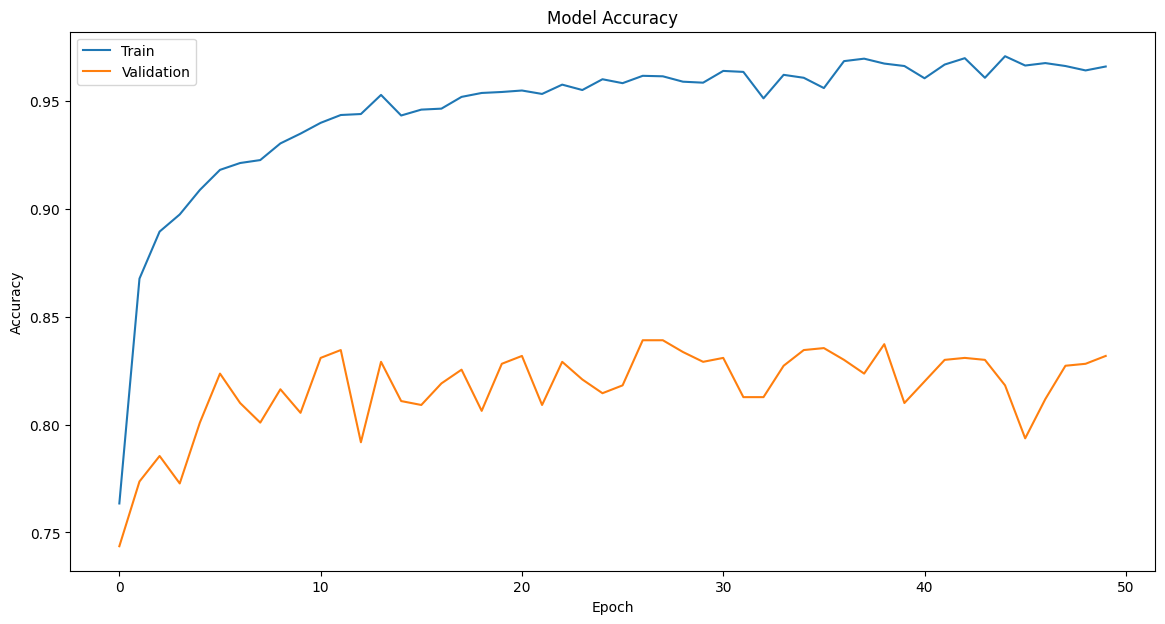

In [13]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Plot the Training and Validation Loss

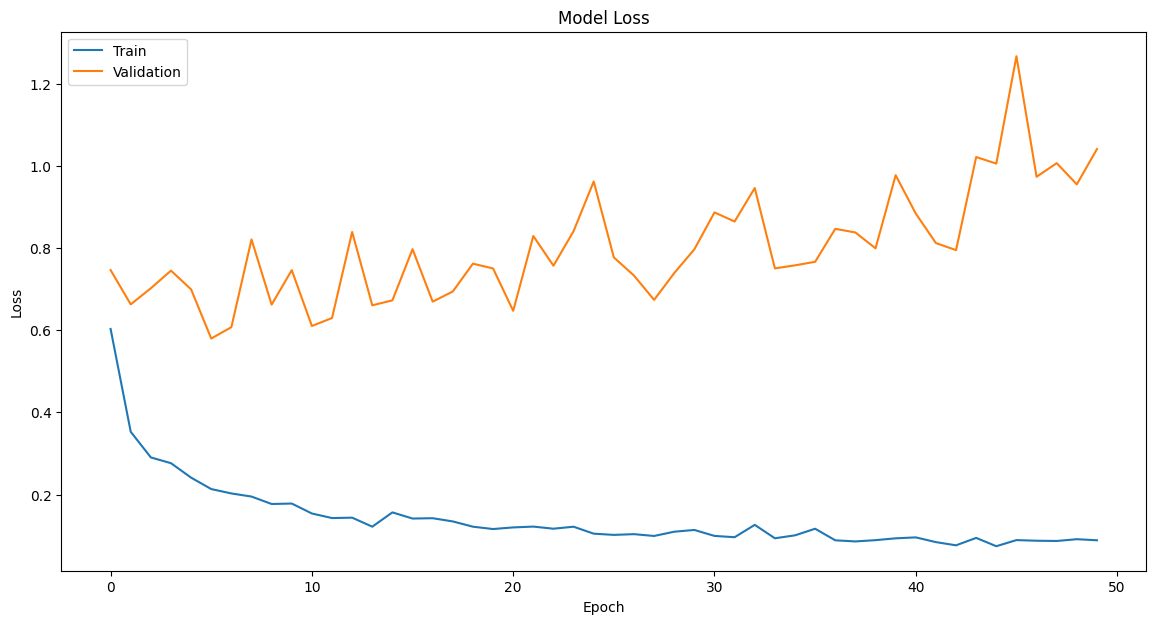

In [14]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Test the model on the test data

In [15]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_acc)

41/41 [==============================] - 724s 18s/step - loss: 0.4996 - accuracy: 0.9071
Test accuracy: 0.9071038365364075


### Generate predictions on the test data

In [16]:
y_pred = model.predict(test_generator, steps=len(test_generator))
y_true = test_generator.classes

41/41 [==============================] - 15s 305ms/step


### Generate and plot confusion matrix

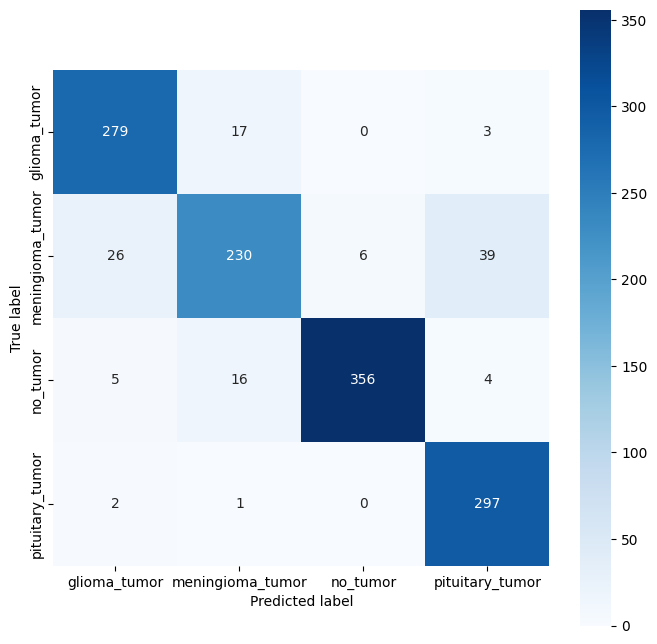

In [17]:
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Blues", square=True, xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Print classification report

In [18]:
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=class_names))

                  precision    recall  f1-score   support

    glioma_tumor       0.89      0.93      0.91       299
meningioma_tumor       0.87      0.76      0.81       301
        no_tumor       0.98      0.93      0.96       381
 pituitary_tumor       0.87      0.99      0.92       300

        accuracy                           0.91      1281
       macro avg       0.90      0.91      0.90      1281
    weighted avg       0.91      0.91      0.91      1281



### Compute precision, recall, F1 score and support for each class

In [19]:
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, np.argmax(y_pred, axis=1))

In [20]:
# Create a dataframe with the computed metrics for each class
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score,
    'Support': support
}, index=class_names)

# Print the dataframe
print(metrics_df)

                  Precision    Recall  F1 Score  Support
glioma_tumor       0.894231  0.933110  0.913257      299
meningioma_tumor   0.871212  0.764120  0.814159      301
no_tumor           0.983425  0.934383  0.958277      381
pituitary_tumor    0.865889  0.990000  0.923795      300


### Compute ROC and AUC for each class

In [21]:
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC and AUC for each class
for i in range(train_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

### Plot ROC curve for each class

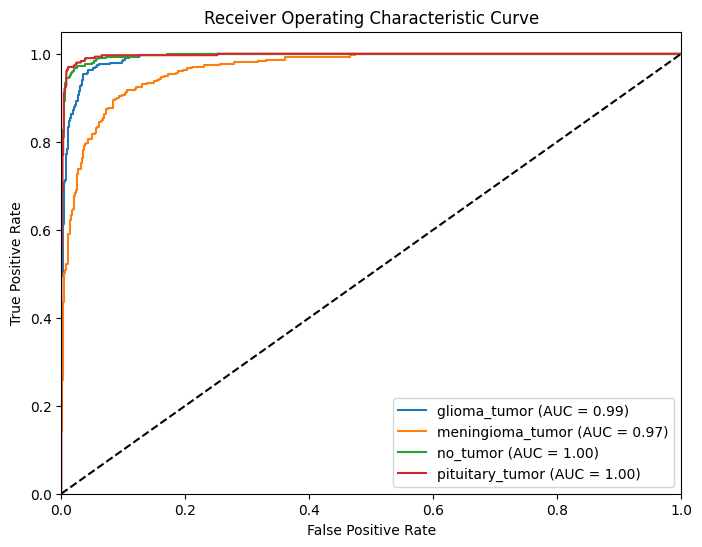

In [22]:
plt.figure(figsize=(8, 6))
for i in range(train_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label='%s (AUC = %0.2f)' % (class_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()